<a href="https://colab.research.google.com/github/Qvery-mm/NumericMethods_3/blob/main/6_term_lab02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вычислительный практикум, 6 семестр
# Задание №2
# Задача Штурма-Лиувилля
### Ковальчуков Александр
### 321 группа
### Вариант №6

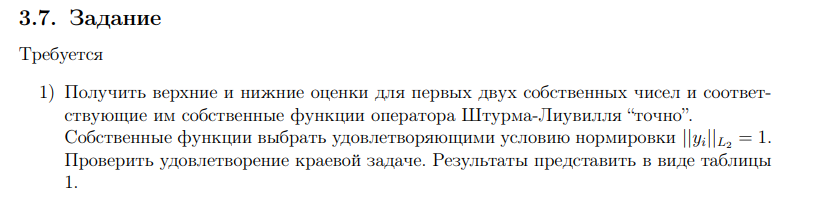

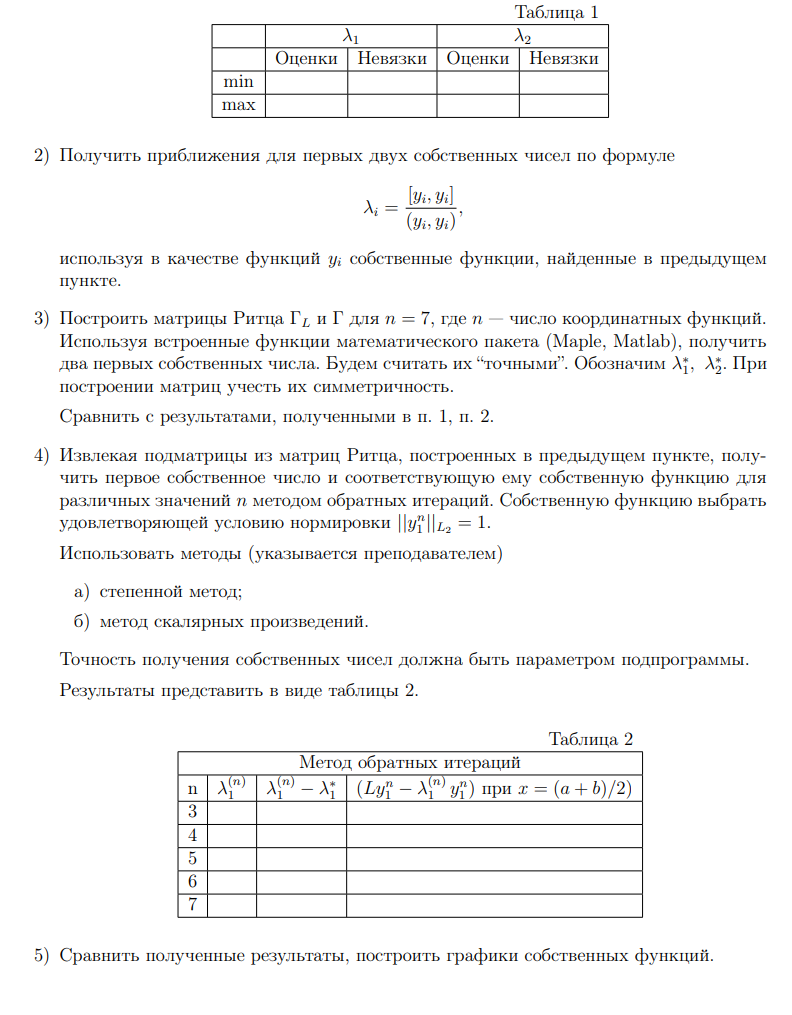

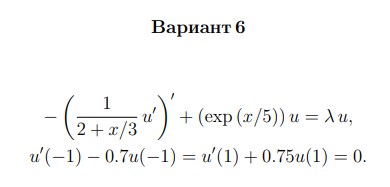

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import jacobi
from math import *

Заведём для удобства символьные переменные

In [2]:
def p(x): return 1.0 / (2 + x / 3.0)
def q(x): return exp(x / 5.0)
alpha_1 = -0.7
alpha_2 = -1
beta_1 = 0.75
beta_2 = 1

Количество функций в координатной системе

In [3]:
n = 7

Для численного интегрирования воспользуемся формулой Симпсона

In [4]:
def integrate(a, b, func, m=20):
    h = (b - a) / m
    alpha = a + h / 2
    beta = a + h
    return h / 6 * (func(a) + 4 * sum( func(alpha + k * h) for k in range(m)) +
                    func(b) + 2 * sum( func(beta + k * h) for k in range(m - 1)))

Численное дифференцирование

In [5]:
def d(f):
  epsilon = 1e-10
  return lambda x: (f(x + epsilon) - f(x-epsilon)) / (2 * epsilon)

def d2(f):
  epsilon = 1e-5
  return lambda x: (f(x - epsilon) - 2 * f(x) + f(x+epsilon)) / epsilon**2

Определим скаляроное произведение в $L_2[-1, 1]$

In [6]:
def dot(y, z, n = 200):
  return integrate(-1, 1, lambda x: y(x) * z(x), n)

In [7]:
def norm(f):
  return sqrt(dot(f, f))

И энергетическое скалярное произведение для III задачи на концах промежутка

In [8]:
def bilinear_form(y, z):
  def under_intergal(x):
    return p(x) * d(y)(x) * d(z)(x) + q(x) * y(x) * z(x)
  return integrate(-1, 1, under_intergal) + alpha_1/alpha_2 * p(-1) * y(-1) * z(-1) + beta_1/beta_2 * p(1) * y(1) * z(1)

# Оценки на собственные числа

Частоты $\nu$ определяем из уранения: $(\alpha_1\beta_1 - \alpha_2\beta_2 \nu^2) \sin 2\nu + (\alpha_1\beta_2 - \alpha_2\beta_1) \nu \cos 2\nu = 0$

In [9]:
x = np.linspace(-1, 1, 1000)
p_max = max(map(p, x))
p_min = min(map(p, x))
q_max = max(map(q, x))
q_min = min(map(q, x))

print("Оценки на 2 первых собственных числа:")
nu1 = 0.760936
print(nu1**2 * p_min + q_min, "< lambda_1 <", nu1**2 * p_max + q_max)
nu2 = 1.9300737
print(nu2**2 * p_min + q_min, "< lambda_2 <", nu2**2 * p_max + q_max)
# nu3 = 3.35443912
# print(nu3**2 * p_min + q_min, nu3**2 * p_max + q_max)

Оценки на 2 первых собственных числа:
1.0668837228334103 < lambda_1 < 1.5688169158177698
2.415238390548706 < lambda_2 < 3.456513450619184


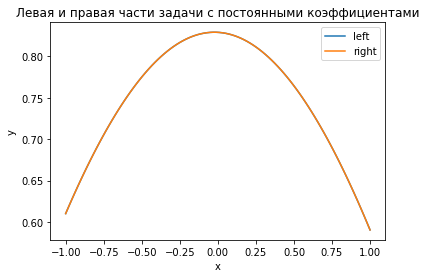

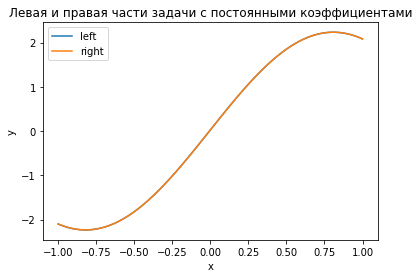

In [10]:
def do_smth(nu):
  C = (beta_2 * nu * sin(nu) - beta_1 * cos(nu)) / (beta_1 * sin(nu) + beta_2 * nu * cos(nu)) 
  def eig_f(x): return cos(nu*x) + C * sin(nu*x)
  norm_eig_f = lambda x: eig_f(x) / norm(eig_f)
  u = norm_eig_f
  right = lambda x: (nu**2 * p_min + q_min)  * u(x)
  # left = lambda x: -d(lambda x: p(x) * d(u)(x))(x) + q(x)*u(x)
  left = lambda x: -p_min * d2(u)(x) + q_min * u(x) 
  # left = lambda x:  q(x)*u(x)
  x = np.linspace(-1, 1, 100)

  right = list(map(right, x))
  left = list(map(left, x))
  plt.plot(x, left, label='left')
  plt.plot(x, right, label='right')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.title('Левая и правая части задачи с постоянными коэффициентами')
  plt.show()
  return norm_eig_f

norm_eig_f_1 = do_smth(nu1)
norm_eig_f_2 = do_smth(nu2)


# Приближения первых двух собственных чисел по формуле:

$$ \lambda_i = \dfrac{[y_i, y_i]}{(y_i, y_i)} \stackrel{\text{ОНС}}{=} [y_i, y_i] $$

In [11]:
bilinear_form(norm_eig_f_1, norm_eig_f_1) 

1.300551026965909

In [12]:
bilinear_form(norm_eig_f_2, norm_eig_f_2) 

2.890916789657743

# Метод Ритца

Ортогональная нормированная система

In [13]:
def omega(x, i): return sqrt((2 * i - 1) / 2.0) * jacobi(n=i-1, alpha=0, beta=0)(x)

def omega_i(i): return lambda x: omega(x, i)


Строим матрицу $\Gamma_L = \| [\omega_k, \omega_j] \|$, где $[\cdot, \cdot]$ - энергетическое скалярное произведение. Поскольку координатную систему мы взяли ортонормированной, матрицу $\Gamma_C$ строить не нужно. Она будет просто единичной. 

In [14]:
Gamma_L = np.zeros((n, n))
for i in range(1, n+1):
  for j in range(1, n+1):
    Gamma_L[i-1, j-1] = bilinear_form(omega_i(i), omega_i(j))


Посчитаем собственные числа и векторы получившейся матрицы, не забыв отсортировать сч по возрастанию:

In [15]:
eigs_unsorted = list(np.linalg.eig(Gamma_L))
eigs_unsorted[1] = eigs_unsorted[1].T
eigs = []
for i in range(n):
  eigs.append([eigs_unsorted[0][i], eigs_unsorted[1][i]])
eigs.sort()
eigs

[[1.2989129409567899,
  array([ 9.94808022e-01, -3.91055797e-02, -9.37410882e-02,  6.04105641e-03,
          1.95560521e-03, -2.02671287e-04, -2.51105376e-05])],
 [2.887943718796403,
  array([-4.19244888e-02, -9.79951215e-01, -2.34628729e-02,  1.92869102e-01,
          9.54825675e-03, -9.86551554e-03, -6.77802494e-04])],
 [6.656429959533901,
  array([-0.08811287,  0.01586992, -0.93939359, -0.06748524,  0.32131802,
          0.02608264, -0.0323128 ])],
 [13.23441549041434,
  array([ 0.00107229, -0.1828313 ,  0.02617579, -0.90018331, -0.12704524,
          0.3684637 ,  0.06041866])],
 [23.39878288315083,
  array([ 0.02707053, -0.02167073,  0.30683226, -0.10625711,  0.83343152,
          0.0674041 , -0.44069212])],
 [97.22638433967084,
  array([-0.0022695 , -0.0617469 , -0.02124783, -0.35943634, -0.08453646,
         -0.89987533, -0.22274243])],
 [181.8019550206357,
  array([-0.00981549,  0.01431541, -0.11366226,  0.08599837, -0.42280578,
          0.22167069, -0.8668802 ])]]

А теперь на основе сообственных векторов построим приближения к собственным функциям задачи Штурма-Лиувилля

In [16]:
for i in range(n):
  eigs[i].append(lambda x: sum([eigs[i][1][j] * omega(x, j+1) for j in range(0, n)]))


Можно проверить, что построенные функции удовлетворяют краевым условиям.

Левым:

In [17]:
for i in range(n):
  print(alpha_2 * d(eigs[i][2])(-1) - alpha_1 * eigs[i][2](-1))

0.00015902330154993205
0.007255593362216928
-0.18113738128979096
-1.2900863076921354
-4.7600398396365415
23.399799059526355
-67.49591895433299


И правым:

In [18]:
for i in range(n):
  print(beta_2 * d(eigs[i][2])(1) + beta_1 * eigs[i][2](1))

-4.9195651938394036e-05
-0.0103633716042002
0.06416428328184298
2.459427624606984
-2.4963710090909466
-52.316510344062266
-49.08645799265024


Видно, что первые 2 собственных функции подсчитаны с достаточной точностью.

Теперь посмотрим на величину невязки.

Построим сначала графики для наглядности:

In [19]:
def show(eig_f, eig_v):
  u = eig_f
  right = lambda x: eig_v * u(x)
  left = lambda x: -(d(p)(x) * d(u)(x) + p(x) * d2(u)(x)) + q(x)*u(x) 
  x = np.linspace(-1, 1, 100)

  right = list(map(right, x))
  left = list(map(left, x))
  plt.plot(x, left, label='left')
  plt.plot(x, right, label='right')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.title('Графики левой и правой части уравнения на собственные функции')
  plt.show()

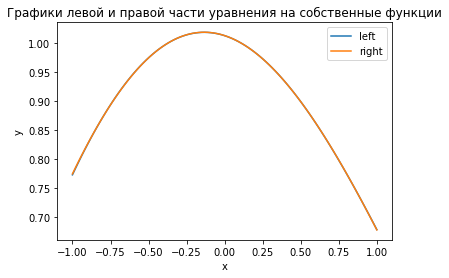

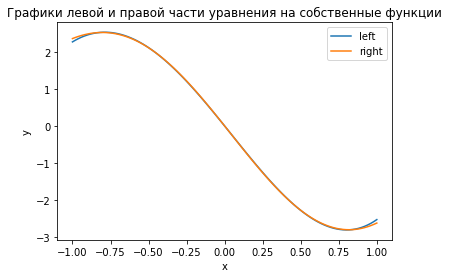

In [20]:
for i in range(2):
  show(eigs[i][2], eigs[i][0])

А теперь посчитаем $L_2$-норму разности левой и правой части.

In [21]:
for i in range(2):
  u = eigs[i][2]
  right = lambda x: eigs[i][0] * u(x)
  left = lambda x: -(d(p)(x) * d(u)(x) + p(x) * d2(u)(x)) + q(x)*u(x) 
  diff = lambda x: left(x) - right(x)
  print(norm(diff))

0.0004041859407804338
0.02834623768316213


## И теперь, когда мы подсчитали "точные" значения собственных чисел, можно проверить оценки из пункта 1.


In [22]:
data = {' ': ['min', 'max'],
        'оценка lambda_1;': [nu1**2 * p_min + q_min, nu1**2 * p_max + q_max],
        'невязка lambda_1;': [nu1**2 * p_min + q_min - eigs[0][0], nu1**2 * p_max + q_max - eigs[0][0]],
        'оценка lambda_2;': [nu2**2 * p_min + q_min , nu2**2 * p_max + q_max],
        'невязка lambda_2;': [nu2**2 * p_min + q_min - eigs[1][0] , nu2**2 * p_max + q_max - eigs[1][0]]}
pd.DataFrame(data)

,,оценка lambda_1;,невязка lambda_1;,оценка lambda_2;,невязка lambda_2;
0,min,1.066884,-0.232029,2.415238,-0.472705
1,max,1.568817,0.269904,3.456513,0.568570


# Метод обратных итераций

In [23]:
columns = ['n', 'lambda(n)', 'lambda_diff', 'L*y-lambda*y']
table = pd.DataFrame(columns=columns)
lamb1_ex = eigs[0][0]

Размер подматрицы: 3
Наименьшееe по величине собственное число: 1.299547940751332
Норма разности: 0.06836394005370675


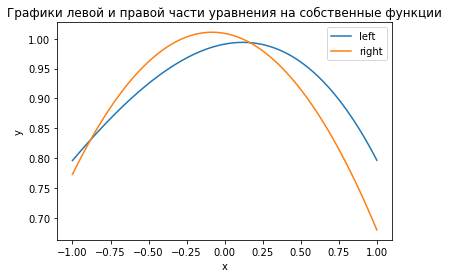

Размер подматрицы: 4
Наименьшееe по величине собственное число: 1.2990323291859476
Норма разности: 0.05150811590595084


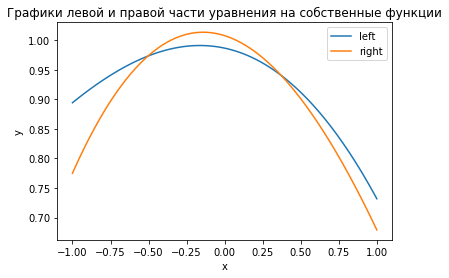

Размер подматрицы: 5
Наименьшееe по величине собственное число: 1.2989152356731877
Норма разности: 0.008840046538680525


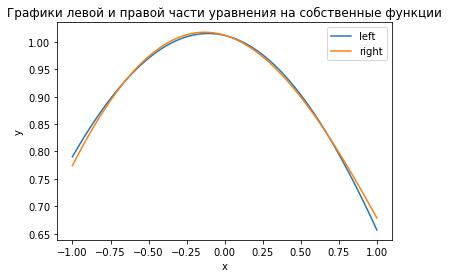

Размер подматрицы: 6
Наименьшееe по величине собственное число: 1.29891326916837
Норма разности: 0.002286200592247402


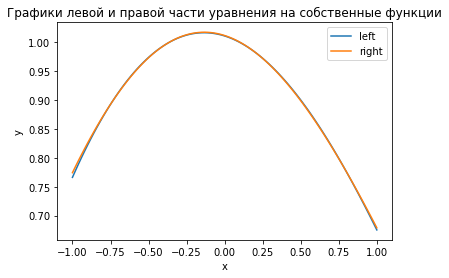

Размер подматрицы: 7
Наименьшееe по величине собственное число: 1.2989132239907946
Норма разности: 0.0007323391652806071


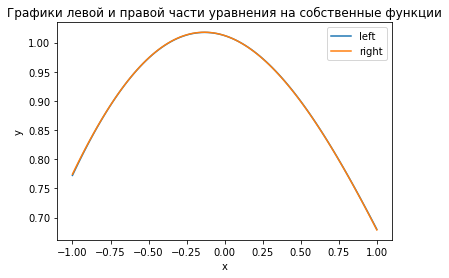

In [24]:
for k in range(3, n+1):
  G = np.linalg.inv(Gamma_L[:k,:k])
  x0 = 1.0 / k * np.ones((k, 1))
  accuracy = 10
  for i in range(accuracy):
    x1 = np.dot(G, x0)
    lamb = np.linalg.norm(x1, 2) / np.linalg.norm(x0, 2)
    x1 = x1 / np.linalg.norm(x1, 2)
    x0 = x1
  eigva = 1/lamb
  print("Размер подматрицы:", k)
  print("Наименьшееe по величине собственное число:", eigva)
  eig_f = lambda x: sum([x0[j] * omega(x, j+1) for j in range(0, k)])
  u = eig_f
  right = lambda x: eigva * u(x)
  left = lambda x: -(d(p)(x) * d(u)(x) + p(x) * d2(u)(x)) + q(x)*u(x) 
  diff = lambda x: left(x) - right(x)
  print("Норма разности:", norm(diff))
  show(eig_f, eigva)

  row = {'n': k, 'lambda(n)': eigva, 'lambda_diff': eigva - lamb1_ex, 'L*y-lambda*y': right(0) - left(0)}
  table = table.append(row, ignore_index=True)
  

In [25]:
table

,n,lambda(n),lambda_diff,L*y-lambda*y
0,3,1.299548,6.349998e-04,[0.017980631218535548]
1,4,1.299032,1.193882e-04,[0.02110992729786465]
2,5,1.298915,2.294716e-06,[0.00036524885588162803]
3,6,1.298913,3.282116e-07,[0.0007057933278238337]
4,7,1.298913,2.830340e-07,[6.115135384865411e-05]
